In [1]:
!pip install -U spacy
!python -m spacy download en

     |████████████████████████████████| 29.8MB 49.6MB/s 
     |████████████████████████████████| 184kB 43.2MB/s 
     |████████████████████████████████| 3.2MB 32.8MB/s 
     |████████████████████████████████| 2.1MB 42.2MB/s 
  Found existing installation: thinc 6.12.1
    Uninstalling thinc-6.12.1:
      Successfully uninstalled thinc-6.12.1
  Found existing installation: spacy 2.0.18
    Uninstalling spacy-2.0.18:
      Successfully uninstalled spacy-2.0.18
     |████████████████████████████████| 11.1MB 4.1MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-kfygrp5p/wheels/39/ea/3b/507f7df78be8631a7a3d7090962194cf55bc1158572c0be77f
Successfully built en-core-web-sm
  Found existing installation: en-core-web-sm 2.0.0
    Uninstalling en-core-web-sm-2.0.0:
      Successfully uninstalled en-core-web-sm-2.0.0
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->


In [0]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Utility
import re
import string
import numpy as np
import os
from collections import Counter
import logging
import time
import random
import pickle
import itertools

# Torch
import torch

# torchtext
import torchtext
from torchtext import data
from torchtext import datasets
import spacy

## Get dataset

In [3]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

--2019-06-02 06:19:22--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2019-06-02 06:19:22--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  19.5MB/s    in 4.0s    

2019-06-02 06:19:26 (19.5 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [4]:
!unzip trainingandtestdata.zip

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


## Prepare Dataset

In [0]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

In [0]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = DATASET_ENCODING , names = DATASET_COLUMNS)

In [7]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
df.target.value_counts()

4    800000
0    800000
Name: target, dtype: int64

In [0]:
decode_map = {0: 0, 4: 1}
def decode_sentiment(label):
    return decode_map[int(label)]

In [10]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 805 ms, sys: 2.21 ms, total: 807 ms
Wall time: 810 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

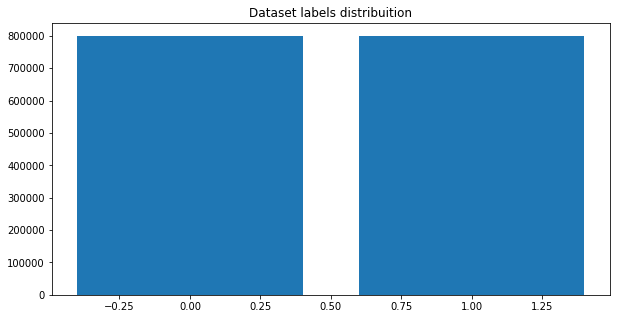

In [11]:
target_cnt = Counter(df.target)

plt.figure(figsize=(10,5))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [12]:
df.target.value_counts()

1    800000
0    800000
Name: target, dtype: int64

## Split train and test

In [13]:
split_frac = 0.95

## split data into training and test data (features and labels, x and y)

split_idx = int(len(df)*0.95)
train, test = df[:split_idx], df[split_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train.shape),
      "\nTest set: \t\t{}".format(test.shape))

			Feature Shapes:
Train set: 		(1520000, 6) 
Test set: 		(80000, 6)


In [0]:
# save train and test as csv
train.to_csv('train.csv', index = None, header=True)
test.to_csv('test.csv', index = None, header=True)

## Pre-Process dataset

In [0]:
def generate_bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return x

In [16]:
generate_bigrams(['This', 'film', 'is', 'terrible'])

['This', 'film', 'is', 'terrible', 'This film', 'film is', 'is terrible']

In [0]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Load Data

In [0]:
# define the columns that we want to process and how to process
TEXT = data.Field(tokenize = 'spacy', preprocessing = generate_bigrams)
LABEL = data.LabelField(dtype = torch.float)

train_val_fields = [
    ('target', LABEL), # we dont need this, so no processing
    ('ids', None), # process it as label
    ('date', None), # we dont need this, so no processing
    ('flag', None), # process it as text
    ('user', None), # process it as text
    ('text', TEXT) # process it as text
]

trainds, testds = data.TabularDataset.splits(path='', 
                                             format='csv', 
                                             train='train.csv', 
                                             validation='test.csv',
                                             fields=train_val_fields, 
                                             skip_header=True)

In [0]:
# create valid dataset
trainds, valds = trainds.split(random_state = random.seed(SEED))

In [20]:
len(trainds), len(valds), len(testds)

(1064000, 456000, 80000)

In [21]:
MAX_VOCAB_SIZE = 100000

TEXT.build_vocab(trainds,
                 testds,
                 valds,
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(trainds,)

.vector_cache/glove.6B.zip: 862MB [00:40, 21.3MB/s]                           
100%|█████████▉| 398846/400000 [00:16<00:00, 23933.12it/s]

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (trainds, valds, testds),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=lambda x: len(x.text),
    sort_within_batch = True,
    repeat=False)

In [23]:
batch = next(train_iterator.__iter__()); batch

100%|█████████▉| 398846/400000 [00:30<00:00, 23933.12it/s]


[torchtext.data.batch.Batch of size 64]
	[.target]:[torch.cuda.FloatTensor of size 64 (GPU 0)]
	[.text]:[torch.cuda.LongTensor of size 11x64 (GPU 0)]

## Build the Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class FastText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
                
        #embedded = [sent len, batch size, emb dim]
        
        embedded = embedded.permute(1, 0, 2)
        
        #embedded = [batch size, sent len, emb dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        
        #pooled = [batch size, embedding_dim]
                
        return self.fc(pooled)

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,000,301 trainable parameters


In [27]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([100002, 100])


In [28]:
# replace the initial weights of the embedding layer with the pre-trained embeddings
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [ 0.3847,  0.4935,  0.4910,  ...,  0.0263,  0.3905,  0.5222],
        ...,
        [-0.3346, -1.7735, -0.3802,  ...,  0.0376,  1.8091,  0.0537],
        [-1.8044, -1.2724,  1.2694,  ...,  0.9493,  0.5378, -0.1330],
        [ 0.2133, -1.9291, -0.9299,  ...,  1.7200,  0.1525, -1.3403]])

In [29]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3847,  0.4935,  0.4910,  ...,  0.0263,  0.3905,  0.5222],
        ...,
        [-0.3346, -1.7735, -0.3802,  ...,  0.0376,  1.8091,  0.0537],
        [-1.8044, -1.2724,  1.2694,  ...,  0.9493,  0.5378, -0.1330],
        [ 0.2133, -1.9291, -0.9299,  ...,  1.7200,  0.1525, -1.3403]])


## Train the Model

In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [0]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.target)
        
        acc = binary_accuracy(predictions, batch.target)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.target)
            
            acc = binary_accuracy(predictions, batch.target)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [36]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 8s
	Train Loss: 0.430 | Train Acc: 80.14%
	 Val. Loss: 0.401 |  Val. Acc: 82.14%
Epoch: 02 | Epoch Time: 2m 6s
	Train Loss: 0.376 | Train Acc: 83.46%
	 Val. Loss: 0.398 |  Val. Acc: 82.37%
Epoch: 03 | Epoch Time: 2m 7s
	Train Loss: 0.364 | Train Acc: 84.13%
	 Val. Loss: 0.399 |  Val. Acc: 82.34%
Epoch: 04 | Epoch Time: 2m 5s
	Train Loss: 0.358 | Train Acc: 84.45%
	 Val. Loss: 0.400 |  Val. Acc: 82.31%
Epoch: 05 | Epoch Time: 2m 5s
	Train Loss: 0.354 | Train Acc: 84.68%
	 Val. Loss: 0.402 |  Val. Acc: 82.26%
Epoch: 06 | Epoch Time: 2m 5s
	Train Loss: 0.352 | Train Acc: 84.84%
	 Val. Loss: 0.403 |  Val. Acc: 82.20%
Epoch: 07 | Epoch Time: 2m 5s
	Train Loss: 0.350 | Train Acc: 84.93%
	 Val. Loss: 0.405 |  Val. Acc: 82.13%
Epoch: 08 | Epoch Time: 2m 5s
	Train Loss: 0.348 | Train Acc: 85.04%
	 Val. Loss: 0.405 |  Val. Acc: 82.18%
Epoch: 09 | Epoch Time: 2m 5s
	Train Loss: 0.347 | Train Acc: 85.10%
	 Val. Loss: 0.406 |  Val. Acc: 82.17%
Epoch: 10 | Epoch Time: 2m 4

In [37]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.495 | Test Acc: 78.71%


## User Input


In [0]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = generate_bigrams([tok.text for tok in nlp.tokenizer(sentence)])
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

In [39]:
# An example negative review...
predict_sentiment(model, "This film is terrible")

0.0016955053433775902

In [40]:
# An example positive review...
predict_sentiment(model, "This film is great")

0.9965022802352905